In [1]:
import pandas as pd
import numpy as np
import random
import scipy.stats
import pickle, os, time
import itertools
from datetime import datetime, timedelta
from collections import Counter, defaultdict, namedtuple
from PIL import Image
import yaml
from tqdm import tqdm

from sklearn import preprocessing, model_selection, metrics, utils
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
from joblib import Parallel, delayed
from sklearn.base import clone

import seaborn as sns
from matplotlib import pyplot as plt

data_dir = '/data/GVHD/'

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

## Helper functions

### Model training

In [3]:
def train_model(Xtr, ytr):
    np.random.seed(42)
    random.seed(42)
    
    # Specify hyperparameters and cv parameters
    base_estimator = LogisticRegression(
        penalty='l2', 
        class_weight='balanced', 
        solver='liblinear'
    )
    param_grid = {
        'C': [10. ** n for n in range(-6, 7)],
        'penalty': ['l2'],
    }
    
    cv_splits, cv_repeat = 5, 20
    cv = model_selection.RepeatedStratifiedKFold(cv_splits, cv_repeat, random_state=0)
    clf = model_selection.GridSearchCV(
        clone(base_estimator), param_grid, 
        cv=cv, scoring='roc_auc', iid=False, n_jobs=5,
    )
    clf.fit(Xtr, ytr)
    return clf

### Evaluation

In [4]:
def boostrap_func_all(i, y_true, y_prob, threshold):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_prob)
    y_true_b, y_prob_b = utils.resample(y_true, y_prob, replace=True, random_state=i)
    y_pred_b = (y_prob_b > threshold)
    tpr_cutoff = metrics.recall_score(y_true_b, y_pred_b)
    idx = (np.abs(tpr - tpr_cutoff)).argmin()
    
    return (
        metrics.roc_auc_score(y_true_b, y_prob_b), # AUC
        tpr[idx], # sensitivity
        1-fpr[idx], # specificity
        metrics.precision_score(y_true_b, y_pred_b), # positive predictive value
    )

def boostrap_func_confusion(i, y_true, y_prob, threshold):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_prob)
    y_true_b, y_prob_b = utils.resample(y_true, y_prob, replace=True, random_state=i)
    y_pred_b = (y_prob_b > threshold)
    tpr_cutoff = metrics.recall_score(y_true_b, y_pred_b)
    idx = (np.abs(tpr - tpr_cutoff)).argmin()
    
    return metrics.confusion_matrix(y_true_b, y_pred_b).ravel()

In [5]:
def evaluate_model(clf, Xte, yte, Xtr=None, threshold_p=55, verbose=True):
    y_true = yte
    y_score = clf.decision_function(Xte)
    y_prob = clf.predict_proba(Xte)[:,1]
    
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score)
    test_auc = metrics.roc_auc_score(y_true, y_score)
    
    # Picking a risk threshold based on training set if possible
    if Xtr is not None:
        if verbose: print('Risk threshold based on train set')
        threshold = np.percentile(clf.predict_proba(Xtr)[:,1], threshold_p)
    else:
        if verbose: print('Risk threshold based on test set')
        threshold = np.percentile(y_score, 55)
    if verbose: print('p_Threshold', threshold)
    
    if verbose: print()
    if verbose: print('Confusion matrix (95%CI lower, upper)')
    y_pred = (y_prob > threshold)
    conf_mat = metrics.confusion_matrix(y_true, y_pred)
    if verbose: print(conf_mat) # Rows: actual 0, actual 1; Cols: predicted 0, predicted 1
    
    confmats = [boostrap_func_confusion(i, y_true, y_prob, threshold) for i in range(1000)]
    confmats_ = np.asarray(confmats)
    if verbose: print(np.percentile(confmats_, 2.5, axis=0).reshape(2,2))
    if verbose: print(np.percentile(confmats_, 97.5, axis=0).reshape(2,2))

    if verbose: print()
    if verbose: print('scores')
    tpr_ = metrics.recall_score(y_true, y_pred)
    idx = (np.abs(tpr - tpr_)).argmin()
    if verbose: print('AUROC={:.3f}'.format(test_auc))
    if verbose: print('TPR={:.3f}, FPR={:.3f} PPV={:.3f}'.format(
        tpr[idx], fpr[idx],
        metrics.precision_score(y_true, y_pred)))

    if verbose: print()
    if verbose: print('scores (95%CI lower, upper)')
    auc_scores, sensitivities, specificities, ppvs = zip(*[boostrap_func_all(i, y_true, y_prob, threshold) for i in range(1000)])
    if verbose: print('Test AUC {:.3f} ({:.3f}, {:.3f})'.format(np.median(auc_scores), np.percentile(auc_scores, 2.5), np.percentile(auc_scores, 97.5)))
    if verbose: print('Test AUC {:.3f} ± {:.3f}'.format(np.mean(auc_scores), np.std(auc_scores)))
    if verbose: print('sens.\t {:.1%} ({:.1%}, {:.1%})'.format(np.mean(sensitivities), np.percentile(sensitivities, 2.5), np.percentile(sensitivities, 97.5)))
    if verbose: print('spec.\t {:.1%} ({:.1%}, {:.1%})'.format(np.mean(specificities), np.percentile(specificities, 2.5), np.percentile(specificities, 97.5)))
    if verbose: print('prec.\t {:.1%} ({:.1%}, {:.1%})'.format(np.mean(ppvs), np.percentile(ppvs, 2.5), np.percentile(ppvs, 97.5)))
    
    return test_auc, auc_scores, fpr, tpr

## Data loading

In [8]:
pop = pd.read_csv('data/population.csv').set_index('BMT_ID')
extracted_features = pd.read_csv('output/ts_features.csv', index_col='id')
df_label = pop.join(pd.read_csv('data/label.csv', index_col='BMT_ID'), how='left')
df_features = pd.read_csv('output/df_features.csv', index_col='id')
feature_names = df_features.columns

In [10]:
with np.load('output/Xy.npz') as f:
    X = f['X']
    y = f['y']

### Temporal split

In [11]:
split_idx = -85
assert pop[:split_idx].index.str.startswith('train_').all()
assert pop[split_idx:].index.str.startswith('test_').all()

In [12]:
Xtr_all, Xte_all = X[:split_idx], X[split_idx:]
ytr, yte = y[:split_idx], y[split_idx:]

## Main model

In [13]:
Xtr, Xte = Xtr_all, Xte_all
clf = train_model(Xtr, ytr)
auc_main, auc_scores_main, fpr_main, tpr_main = evaluate_model(clf, Xte, yte, Xtr, 55, verbose=False)

In [14]:
clf.best_params_

{'C': 0.01, 'penalty': 'l2'}

## Sensitivity Analyses

### Omitting specific subsets

In [15]:
df_corr = df_features.corr().abs()
np.fill_diagonal(df_corr.values, 0)

In [16]:
feature_groups = []
feature_groups_desc = []
for variable, stat in itertools.product(
    ['Temp', 'HR', 'RR', 'SysBP', 'DiaBP', 'SpO2'],
    ['__mean_', 'slope', 'sample_entropy', 'abs', 'angle']
):
    to_drop = [i for i, name in enumerate(feature_names) if name.startswith(variable) and stat in name]
    feature_groups.append(to_drop)
    feature_groups_desc.append((variable, stat))

In [17]:
df_corr_group = []
for (i1, g1), (i2, g2) in itertools.product(enumerate(feature_groups), enumerate(feature_groups)):
#     print(i1,i2)
#     if i1 < i2:
    if i1 != i2:
        co = df_corr.iloc[g1, g2].max().max()
        df_corr_group.append((i1,i2,co))

df_corr_group = pd.DataFrame(df_corr_group)

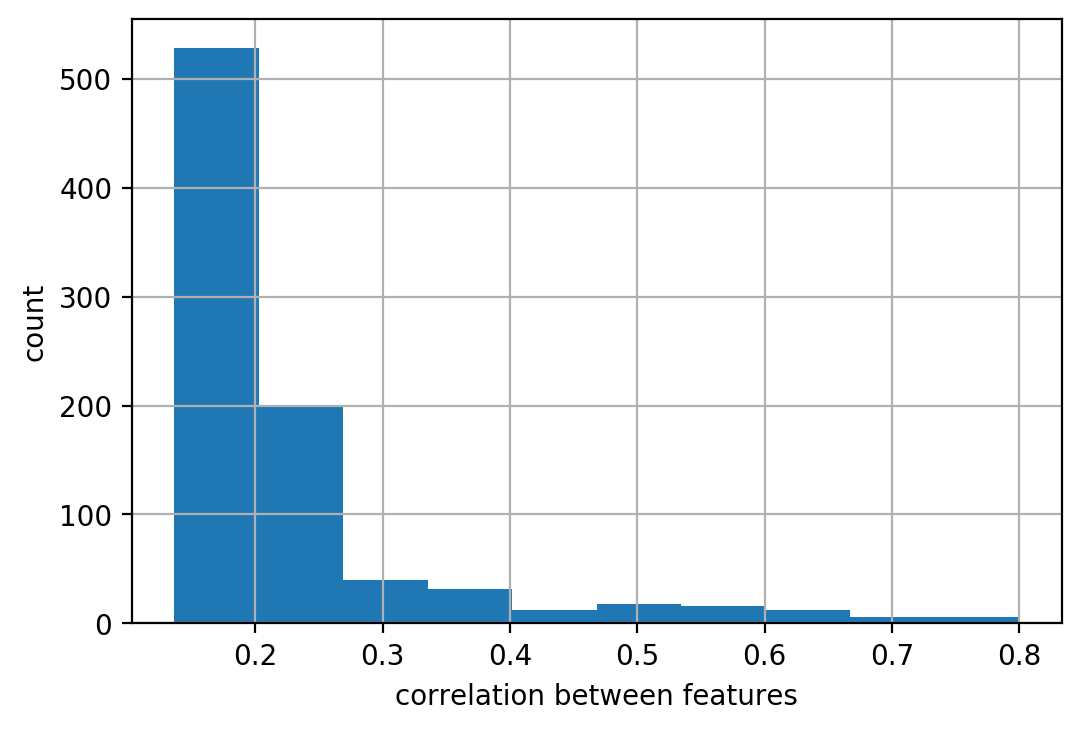

In [18]:
pd.DataFrame(df_corr_group)[2].hist()
plt.xlabel('correlation between features')
plt.ylabel('count')
plt.show()

In [19]:
from collections import defaultdict

In [20]:
grouped_groups = defaultdict(list)
for it, row in df_corr_group[df_corr_group[2] > 0.6].iterrows():
    grouped_groups[int(row[0])].append(int(row[1]))

In [21]:
grouped_groups_ = []
for i, g in grouped_groups.items():
    found = False
    for gg in grouped_groups_:
        if i in gg:
            found = True
            gg = gg | set(g)
    if not found:
        grouped_groups_.append(set(g + [i]))

In [22]:
grouped_groups_

[{1, 3, 4}, {6, 8}, {10, 12}, {15, 20}, {16, 19}, {21, 24}, {25, 26, 27, 28}]

In [23]:
def boostrap_func_auc(i, y_true, y_score):
    yte_true_b, yte_pred_b = utils.resample(y_true, y_score, replace=True, random_state=i)
    return metrics.roc_curve(yte_true_b, yte_pred_b), metrics.roc_auc_score(yte_true_b, yte_pred_b)

results_2 = {}
boot_auc_scores_2 = {}
for gi, (group, (variable, stat)) in enumerate(zip(feature_groups, feature_groups_desc)):
    grouped = False
    for gg in grouped_groups_:
        if gi in gg:
            grouped = True
            to_drop = [i for i, name in enumerate(feature_names) if name in feature_names[
                sum([feature_groups[i] for i in gg], [])]]
            break
    
    if not grouped:
        to_drop = [i for i, name in enumerate(feature_names) if name in feature_names[group]]
    
    to_keep = [i for i in range(652) if i not in to_drop]
    Xtr, Xte = Xtr_all[:, to_keep], Xte_all[:, to_keep]
    print(variable, stat, len(to_keep))
    
    clf = train_model(Xtr, ytr)

    y_true = yte
    y_score = clf.decision_function(Xte)
    roc_curves, auc_scores = zip(*Parallel(n_jobs=4)(delayed(boostrap_func_auc)(i, y_true, y_score) for i in range(1000)))
    print('Test AUC: {:.3f} ({:.3f}, {:.3f})'.format(np.median(auc_scores), np.percentile(auc_scores, 2.5), np.percentile(auc_scores, 97.5)))
    print('Test AUC: {:.3f} ± {:.3f}'.format(np.mean(auc_scores), np.std(auc_scores)))

    results_2[variable, stat] = (np.mean(auc_scores), np.std(auc_scores))
    boot_auc_scores_2[variable, stat] = auc_scores

Temp __mean_ 632
Test AUC: 0.662 (0.539, 0.784)
Test AUC: 0.662 ± 0.064
Temp slope 592
Test AUC: 0.626 (0.500, 0.752)
Test AUC: 0.627 ± 0.066
Temp sample_entropy 632
Test AUC: 0.662 (0.538, 0.788)
Test AUC: 0.662 ± 0.063
Temp abs 592
Test AUC: 0.626 (0.500, 0.752)
Test AUC: 0.627 ± 0.066
Temp angle 592
Test AUC: 0.626 (0.500, 0.752)
Test AUC: 0.627 ± 0.066
HR __mean_ 632
Test AUC: 0.651 (0.534, 0.774)
Test AUC: 0.651 ± 0.063
HR slope 612
Test AUC: 0.666 (0.545, 0.784)
Test AUC: 0.665 ± 0.062
HR sample_entropy 632
Test AUC: 0.655 (0.531, 0.779)
Test AUC: 0.654 ± 0.064
HR abs 612
Test AUC: 0.666 (0.545, 0.784)
Test AUC: 0.665 ± 0.062
HR angle 632
Test AUC: 0.657 (0.529, 0.779)
Test AUC: 0.657 ± 0.064
RR __mean_ 612
Test AUC: 0.634 (0.508, 0.758)
Test AUC: 0.633 ± 0.065
RR slope 632
Test AUC: 0.656 (0.533, 0.783)
Test AUC: 0.657 ± 0.064
RR sample_entropy 612
Test AUC: 0.634 (0.508, 0.758)
Test AUC: 0.633 ± 0.065
RR abs 632
Test AUC: 0.664 (0.542, 0.788)
Test AUC: 0.663 ± 0.063
RR angle 63

In [24]:
df_results_2 = pd.DataFrame(results_2).T
df_results_2.columns = ['AUC_mean', 'AUC_std']
df_results_2.index = [n_a + ' ' + n_b for n_a, n_b in df_results_2.index]

In [25]:
df_results_2['AUC_mean_drop'] = -(df_results_2['AUC_mean'] - 0.659)

In [26]:
df_results_2.sort_values(by='AUC_mean_drop').head()

,AUC_mean,AUC_std,AUC_mean_drop
DiaBP __mean_,0.671861,0.061826,-0.012861
SysBP __mean_,0.671861,0.061826,-0.012861
SpO2 sample_entropy,0.666833,0.061733,-0.007833
SpO2 abs,0.666833,0.061733,-0.007833
SpO2 slope,0.666833,0.061733,-0.007833


In [27]:
df_results_3 = pd.DataFrame(results_2).T
df_results_3.columns = ['AUC_mean', 'AUC_std']
df_results_3['AUC_mean_drop'] = -(df_results_3['AUC_mean'] - 0.659)

In [28]:
df_drop_grid = pd.DataFrame()
for i, j in df_results_3.index:
    df_drop_grid.loc[i,j] = df_results_3.loc[(i,j), 'AUC_mean_drop']

df_drop_grid = df_drop_grid.rename(
    columns={
        '__mean_': 'average', 'abs': 'abs($A_1$)', 'angle': 'angle($A_1$)',
        'sample_entropy': 'entropy'
    },
    index={
        'Temp': 'Temp.', 'SysBP': 'SBP', 'DiaBP': 'DBP',
    }
)
df_drop_grid.index.name = 'Vital'
df_drop_grid.columns.name = 'Trend'

In [29]:
df_drop_grid

Trend,average,slope,entropy,abs($A_1$),angle($A_1$)
Vital,,,,,
Temp.,-0.002578,0.032435,-0.003259,0.032435,0.032435
HR,0.007749,-0.006428,0.005009,-0.006428,0.001755
RR,0.025586,0.002294,0.025586,-0.004335,0.010127
SBP,-0.012861,0.014802,0.029064,0.036455,0.014802
DBP,-0.012861,0.012080,-0.001982,0.002723,0.012080
SpO2,-0.007833,-0.007833,-0.007833,-0.007833,0.017107


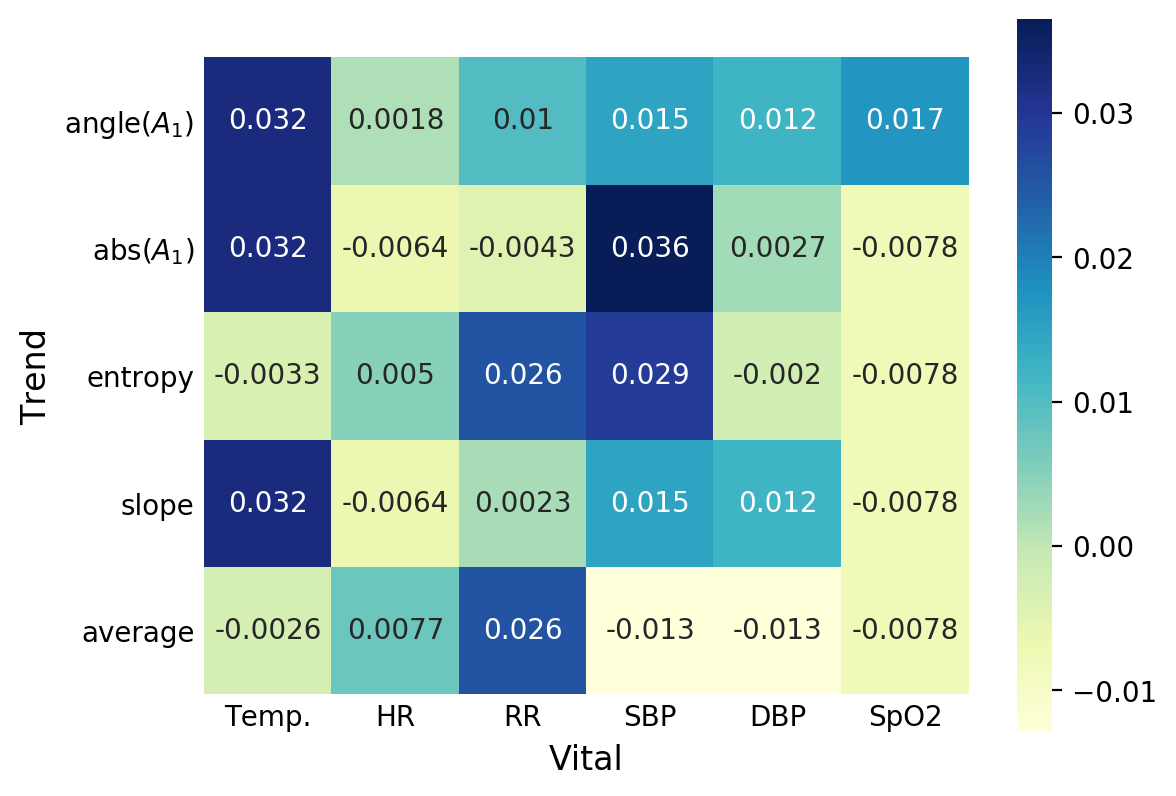

In [30]:
g = sns.heatmap(df_drop_grid.T, cmap="YlGnBu", annot=True, linewidths=0.)
g.set_xticklabels(g.get_xticklabels())#, rotation = 45, ha='right')
g.set_yticklabels(g.get_yticklabels(), rotation = 0)
plt.gca().tick_params(length=0)
plt.gca().set_aspect('equal')
plt.xlabel('Vital', fontsize=12)
plt.ylabel('Trend', fontsize=12)
plt.tight_layout()
plt.savefig('fig/drop_imp_5x6.pdf')
plt.savefig('fig/drop_imp_5x6.svg')
plt.gca().set_ylim(0,5)
plt.show()

In [31]:
df_drop_row = df_drop_grid.mean(axis=1)
df_drop_col = df_drop_grid.mean(axis=0)

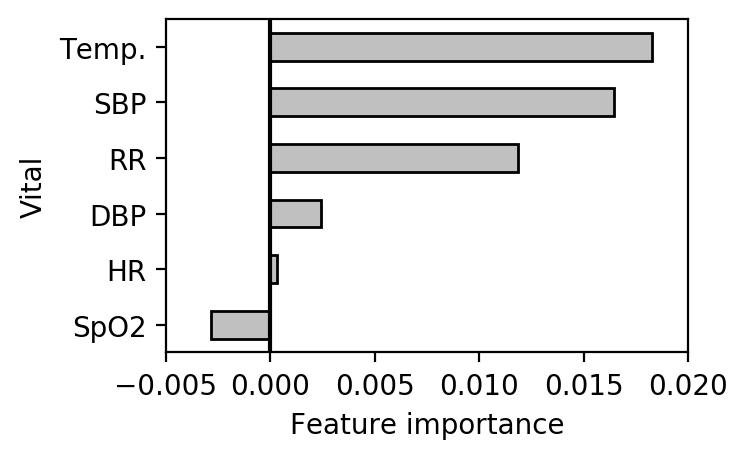

In [32]:
fig = plt.figure(figsize=(3.2*1.2, 2*1.2))
df_drop_row.sort_values().plot.barh(color='silver', edgecolor='k')
plt.axvline(0, c='k')
plt.xlabel('Feature importance')
plt.xlim(-0.005, 0.02)
plt.tight_layout()
plt.savefig('fig/drop_imp_vital.pdf')

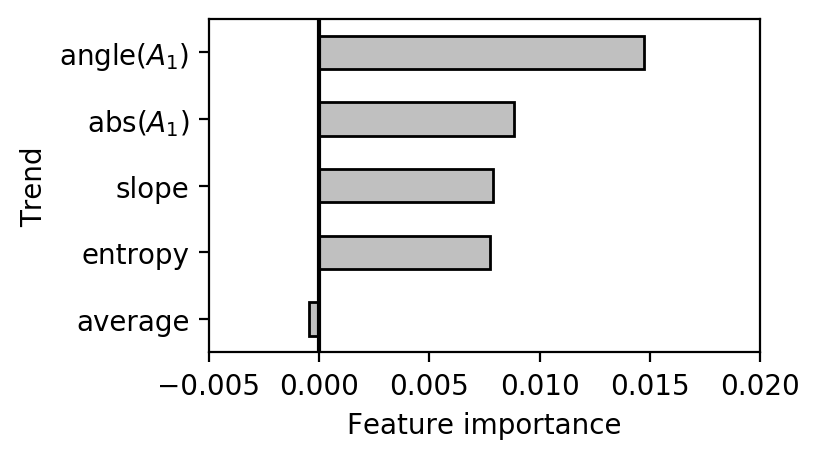

In [33]:
fig = plt.figure(figsize=(3.5*1.2,2*1.2))
df_drop_col.sort_values().plot.barh(color='silver', edgecolor='k')
plt.axvline(0, c='k')
plt.xlabel('Feature importance')
plt.xlim(-0.005, 0.02)
plt.tight_layout()
plt.savefig('fig/drop_imp_trend.pdf')